# ERA5 - download data
From this [website](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview). Follow their instructions on how to [install their CDS API](https://cds.climate.copernicus.eu/api-how-to) and then copy/paste the Python "MARSREQUEST" code into this notebook to download the relevant variables for your budget in netcdf format.

In [2]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            'sea_surface_temperature', 'surface_net_solar_radiation',
        ],
        'year': '2023',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            31, -100, 22,
            -72,
        ],
        'format': 'netcdf',
    },
    'sw_sst_2023.nc')

2024-03-28 20:07:40,357 INFO Welcome to the CDS
2024-03-28 20:07:40,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-03-28 20:07:40,627 INFO Request is queued
2024-03-28 20:07:45,774 INFO Request is running
2024-03-28 20:28:06,003 INFO Request is completed
2024-03-28 20:28:06,004 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.internal-1711657495.0690246-26128-18-62eac4c8-b21f-4b53-a0af-ad8212d531db.nc to sw_sst_2023.nc (139.8M)
2024-03-28 20:28:46,949 INFO Download rate 3.4M/s  


Result(content_length=146539288,content_type=application/x-netcdf,location=https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.internal-1711657495.0690246-26128-18-62eac4c8-b21f-4b53-a0af-ad8212d531db.nc)

## ORAS5: 
> https://www.ecmwf.int/en/research/climate-reanalysis/ocean-reanalysis

> https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-oras5?tab=overview

## MERRA-2: 
> https://disc.gsfc.nasa.gov/api/jobs/results/65f9ca6b7386d42dac131f32

# DOWNLOAD RADIATIVE FLUXES FROM MERRA2 AND UPLOAD TO ZARR
1.	create .netrc file following instructions 1-3 on this page https://urs.earthdata.nasa.gov/documentation/for_users/data_access/curl_and_wget
2.	subset to region, select sw/lw variables, and download list of files as .txt on this page https://disc.gsfc.nasa.gov/datasets/M2T1NXRAD_5.12.4/summary
3.	in terminal in Jupyter hub (same session as when you created .netrc, run :
`wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies --content-disposition -i “downloaded_textfile.txt”`
4.	This will download each nc file for each day for 2023, might take some time (~10min)

In [2]:
import xarray as xr

In [3]:
#Link to get txt file list of diagnostics: https://disc.gsfc.nasa.gov/datasets/M2T1NXOCN_5.12.4/summary
ds = xr.open_mfdataset('MERRA2_400.tavg1_2d_ocn_Nx.*.SUB.nc')

In [4]:
ds

<xarray.Dataset> Size: 25MB
Dimensions:   (time: 7296, lon: 45, lat: 19)
Coordinates:
  * time      (time) datetime64[ns] 58kB 2023-01-01T00:30:00 ... 2023-10-31T2...
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * lat       (lat) float64 152B 22.0 22.5 23.0 23.5 ... 29.5 30.0 30.5 31.0
Data variables:
    TSKINWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Wed Jan 11 22...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_ocn_Nx.20230101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                2023-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2023-01-01
    RangeEndingTime:                   23:59:59.000000
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [5]:
#uploading ocean ds
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/sst.zarr')
ds.to_zarr(gcsmap_ds, mode='w')

In [6]:
#merge and rename to same ocean ds name
ocn_ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean.zarr'))
skin_ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/sst.zarr'))
ocean = xr.merge([ocn_ds, skin_ds])

In [7]:
ocean

<xarray.Dataset> Size: 150MB
Dimensions:   (time: 7296, lat: 19, lon: 45)
Coordinates:
  * lat       (lat) float64 152B 22.0 22.5 23.0 23.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 58kB 2023-01-01T00:30:00 ... 2023-10-31T2...
Data variables:
    EFLUXWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    TSKINICE  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

In [8]:
#upload updated/merged ds
gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean.zarr')
ocean.to_zarr(gcsmap_ds, mode='w')

In [14]:
#make sure upload successful
test_ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean.zarr'))

In [16]:
#success!
test_ds

<xarray.Dataset>
Dimensions:   (time: 7296, lat: 19, lon: 45)
Coordinates:
  * lat       (lat) float64 22.0 22.5 23.0 23.5 24.0 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 -100.0 -99.38 -98.75 -98.12 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 2023-01-01T00:30:00 ... 2023-10-31T23:30:00
Data variables:
    EFLUXWTR  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    TSKINICE  (time, lat, lon) float32 dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

In [1]:
import xarray as xr
sw_url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXRAD.5.12.4/2023/08/MERRA2_400.tavg1_2d_rad_Nx.20230801.nc4?SWGNT[0:1:23][0:1:360][0:1:575]'
lw_url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXRAD.5.12.4/2023/08/MERRA2_400.tavg1_2d_rad_Nx.20230801.nc4?LWGNT[0:1:23][0:1:360][0:1:575]'

sw = xr.open_dataset(sw_url, chunks={})
lw = xr.open_dataset(lw_url, chunks={})

In [2]:
sw

<xarray.Dataset>
Dimensions:  (time: 24, lat: 361, lon: 576)
Dimensions without coordinates: time, lat, lon
Data variables:
    SWGNT    (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    History:                           Original file generated: Sat Aug 12 01...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_rad_Nx.20230801.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    identifier_product_doi:            10.5067/Q9QMY5PBNV1T
    RangeBeginningDate:                2023-08-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2023-08-01
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time

In [13]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os
import requests
import xarray as xr
import s3fs
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
%matplotlib inline

In [14]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')

### us-west-2 Region Check: &#10060;

ValueError: Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets

In [15]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

netrc_name = ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    # Check credentials against URS, and if username exists
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

Enter NASA Earthdata Login Username:  ········
Enter NASA Earthdata Login Password:  ········


In [16]:
url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXRAD.5.12.4/M2T1NXRAD.5.12.4_Aggregation_2023.ncml?lon[0:1:575],lat[0:1:360],time[0:1:8759],LWGNT[0:1:0][0:1:0][0:1:0],SWGNT[0:1:0][0:1:0][0:1:0]'
url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXOCN.5.12.4/catalog.html'
ds = xr.open_dataset(url)

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: HTTP^ Basic: Access denied.


OSError: [Errno -77] NetCDF: Access failure: 'https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXRAD.5.12.4/M2T1NXRAD.5.12.4_Aggregation_2023.ncml?lon[0:1:575],lat[0:1:360],time[0:1:8759],LWGNT[0:1:0][0:1:0][0:1:0],SWGNT[0:1:0][0:1:0][0:1:0]'

In [2]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-oras5',
    {
        'product_type': 'operational',
        'vertical_resolution': 'all_levels',
        'variable': ['zonal_velocity',
        ],
        'year': '2023',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10',
        ],
        'format': 'zip',
    },
    'zonal.zip')

2023-11-29 23:35:03,400 INFO Welcome to the CDS
2023-11-29 23:35:03,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-oras5
2023-11-29 23:35:03,567 INFO Request is queued
2023-11-29 23:35:04,700 INFO Request is running
2023-11-29 23:39:23,273 INFO Request is completed
2023-11-29 23:39:23,274 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data5/dataset-reanalysis-oras5-58422f9b-cc9b-448d-82ff-c5d26048d90c.zip to zonal.zip (1.9G)
2023-11-30 00:12:49,780 INFO Download rate 988.3K/s   


Result(content_length=2030574094,content_type=application/zip,location=https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data5/dataset-reanalysis-oras5-58422f9b-cc9b-448d-82ff-c5d26048d90c.zip)

In [3]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-oras5',
    {
        'product_type': 'operational',
        'vertical_resolution': 'all_levels',
        'variable': ['meridional_velocity',
        ],
        'year': '2023',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10',
        ],
        'format': 'zip',
    },
    'meridional.zip')

2023-11-30 00:12:50,508 INFO Welcome to the CDS
2023-11-30 00:12:50,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-oras5
2023-11-30 00:12:50,657 INFO Request is queued
2023-11-30 00:12:51,788 INFO Request is running
2023-11-30 00:17:10,378 INFO Request is completed
2023-11-30 00:17:10,378 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data9/dataset-reanalysis-oras5-ead363a5-3347-4d0a-b947-3bc142c1aa01.zip to meridional.zip (1.9G)
2023-11-30 00:35:55,632 INFO Download rate 1.7M/s     


Result(content_length=2038567194,content_type=application/zip,location=https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data9/dataset-reanalysis-oras5-ead363a5-3347-4d0a-b947-3bc142c1aa01.zip)

In [2]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-oras5',
    {
        'format': 'zip',
        'vertical_resolution': 'all_levels',
        'variable': 'potential_temperature',
        'year': '2023',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10',
        ],
        'product_type': 'operational',
    },
    'pot-temp.zip')

2023-11-20 15:38:22,762 INFO Welcome to the CDS
2023-11-20 15:38:22,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-oras5
2023-11-20 15:38:22,987 INFO Request is queued
2023-11-20 15:38:24,116 INFO Request is running
2023-11-20 15:42:42,614 INFO Request is completed
2023-11-20 15:42:42,615 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data2/dataset-reanalysis-oras5-89427c8b-6de0-456d-8b1f-8394a8f83cbf.zip to pot-temp.zip (1.7G)
2023-11-20 15:45:20,732 INFO Download rate 11.3M/s    


Result(content_length=1874123662,content_type=application/zip,location=https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data2/dataset-reanalysis-oras5-89427c8b-6de0-456d-8b1f-8394a8f83cbf.zip)

In [3]:
pwd

'/home/jovyan/MHW-WMT'

In [4]:
!unzip '/home/jovyan/MHW-WMT/pot-temp.zip'

Archive:  /home/jovyan/MHW-WMT/pot-temp.zip
  inflating: votemper_control_monthly_highres_3D_202308_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202305_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202309_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202303_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202302_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202310_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202304_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202307_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202306_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202301_OPER_v0.1.nc  


In [3]:
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            'total_precipitation', 
        ],
        'year': ['2023'],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'format': 'netcdf',
    },
    'precip-2023.nc')

2023-11-17 17:21:11,212 INFO Welcome to the CDS
2023-11-17 17:21:11,212 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-17 17:21:11,419 INFO Request is queued
2023-11-17 17:21:12,550 INFO Request is running
2023-11-17 17:37:35,453 INFO Request is completed
2023-11-17 17:37:35,453 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.mars.internal-1700242110.04108-5839-7-57106833-2043-40f8-8b9a-4d4248a326f7.nc to precip-2023.nc (29.3G)
2023-11-17 18:47:10,302 INFO Download rate 7.2M/s       


Result(content_length=31471171008,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.mars.internal-1700242110.04108-5839-7-57106833-2043-40f8-8b9a-4d4248a326f7.nc)

In [3]:
var_list = ['runoff', 'surface_runoff', 'sea_surface_temperature', 'surface_latent_heat_flux', 
            'surface_net_solar_radiation', 'surface_net_thermal_radiation', 'surface_sensible_heat_flux', 
            'e',]
#['sub_surface_runoff', 'surface_solar_radiation_downwards', 'surface_thermal_radiation_downwards',]

for i in var_list:
    print(f'starting {i} download')
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': [
                i, 
            ],
            'year': ['2022'],
            'month': [
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'format': 'netcdf',
        },
        f'2022_winter_{i}.nc')

starting runoff download


2023-10-11 10:54:01,623 INFO Welcome to the CDS
2023-10-11 10:54:01,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-10-11 10:54:01,923 INFO Request is queued
2023-10-11 11:02:22,907 INFO Request is running
2023-10-11 11:06:24,442 INFO Request is completed
2023-10-11 11:06:24,443 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data6/adaptor.mars.internal-1697022201.721435-31617-16-073c0b92-f60f-47a6-bdaf-ec4530043e11.nc to 2022_winter_runoff.nc (4.3G)
2023-10-11 11:15:18,653 INFO Download rate 8.2M/s      
2023-10-11 11:15:19,382 INFO Welcome to the CDS
2023-10-11 11:15:19,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting surface_runoff download


2023-10-11 11:15:19,556 INFO Request is queued
2023-10-11 11:23:40,594 INFO Request is running
2023-10-11 11:29:42,526 INFO Request is completed
2023-10-11 11:29:42,527 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data3/adaptor.mars.internal-1697023500.7263615-16061-7-643dfd50-c5f5-4d23-867f-b7d54b242596.nc to 2022_winter_surface_runoff.nc (4.3G)
2023-10-11 12:07:14,081 INFO Download rate 1.9M/s      
2023-10-11 12:07:14,799 INFO Welcome to the CDS
2023-10-11 12:07:14,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting sea_surface_temperature download


2023-10-11 12:07:15,070 INFO Request is queued
2023-10-11 12:10:07,574 INFO Request is running
2023-10-11 12:15:36,086 INFO Request is completed
2023-10-11 12:15:36,086 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data2/adaptor.mars.internal-1697026277.506086-22861-6-f7b48564-6ef0-45e6-bbb3-67a55c370984.nc to 2022_winter_sea_surface_temperature.nc (4.3G)
2023-10-11 12:21:14,000 INFO Download rate 12.9M/s     
2023-10-11 12:21:14,739 INFO Welcome to the CDS
2023-10-11 12:21:14,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting surface_latent_heat_flux download


2023-10-11 12:21:14,931 INFO Request is queued
2023-10-11 12:25:34,627 INFO Request is running
2023-10-11 12:29:36,085 INFO Request is completed
2023-10-11 12:29:36,086 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.internal-1697027198.8778963-10293-12-4f76fb2e-4818-44b2-887a-f83c2407ae57.nc to 2022_winter_surface_latent_heat_flux.nc (4.3G)
2023-10-11 12:33:49,913 INFO Download rate 17.2M/s     
2023-10-11 12:33:50,630 INFO Welcome to the CDS
2023-10-11 12:33:50,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting surface_net_solar_radiation download


2023-10-11 12:33:50,871 INFO Request is queued
2023-10-11 12:36:43,368 INFO Request is running
2023-10-11 12:42:11,704 INFO Request is completed
2023-10-11 12:42:11,704 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data1/adaptor.mars.internal-1697027927.2623801-16819-7-93589abe-d6c0-47a0-9c6d-ebe19f516171.nc to 2022_winter_surface_net_solar_radiation.nc (4.3G)
2023-10-11 12:48:28,754 INFO Download rate 11.6M/s     
2023-10-11 12:48:29,483 INFO Welcome to the CDS
2023-10-11 12:48:29,483 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting surface_net_thermal_radiation download


2023-10-11 12:48:29,665 INFO Request is queued
2023-10-11 12:54:50,007 INFO Request is running
2023-10-11 12:58:51,226 INFO Request is completed
2023-10-11 12:58:51,226 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data3/adaptor.mars.internal-1697028920.8168418-24110-6-dd5d126e-976f-4910-a4bd-fa57ad3b4ee1.nc to 2022_winter_surface_net_thermal_radiation.nc (4.3G)
2023-10-11 13:07:24,985 INFO Download rate 8.5M/s      
2023-10-11 13:07:25,854 INFO Welcome to the CDS
2023-10-11 13:07:25,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting surface_sensible_heat_flux download


2023-10-11 13:07:26,016 INFO Request is queued
2023-10-11 13:13:46,408 INFO Request is running
2023-10-11 13:19:48,336 INFO Request is completed
2023-10-11 13:19:48,337 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data6/adaptor.mars.internal-1697030178.0263522-13781-6-ab3895cf-68ae-41d1-b01b-db0215e5504a.nc to 2022_winter_surface_sensible_heat_flux.nc (4.3G)
2023-10-11 13:23:51,697 INFO Download rate 18M/s       
2023-10-11 13:23:52,414 INFO Welcome to the CDS
2023-10-11 13:23:52,414 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting e download


2023-10-11 13:23:52,616 INFO Request is queued
2023-10-11 13:30:13,045 INFO Request is running
2023-10-11 13:34:14,409 INFO Request is completed
2023-10-11 13:34:14,410 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data5/adaptor.mars.internal-1697031081.1520853-19406-5-325333a1-96dd-4e1a-bcde-fe2a3276c8e8.nc to 2022_winter_e.nc (4.3G)
2023-10-11 14:17:26,384 INFO Download rate 1.7M/s      


In [ ]:
'runoff', 'sub_surface_runoff', 'surface_runoff', 'sea_surface_temperature', 'surface_latent_heat_flux', 
'surface_net_solar_radiation', 'surface_net_thermal_radiation', 'surface_sensible_heat_flux', 
'surface_solar_radiation_downwards', 'surface_thermal_radiation_downwards',

# Global Ocean Physics Analysis and Forecast
[LINK TO DS](https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_PHY_001_024/services)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import dask

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    jan = xr.open_dataset('cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1705547215051.nc', chunks={})
    feb_may = xr.open_dataset('cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1705547489355.nc', chunks={})
    june_sept = xr.open_dataset('cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1705547753006.nc', chunks={})
    october = xr.open_dataset('cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1705548533127.nc', chunks={})

In [15]:
ds = xr.merge([jan.isel(time=slice(0, -1)), feb_may, june_sept, october])
ds

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/no

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, time: 304, longitude: 337)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(304, 50, 109, 337), meta=np.ndarray>
Attributes: (12/13)
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    title:             daily mean fields from Global Ocean Physics Analysis a...
    area:              Global
    Conventions:       CF-1.8
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    ...                ...
    source:            MOI GLO12
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    institution:       Mercator Ocean International
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    comment:           
    history:           Data extracted from dataset http://localhost:8080/thre...

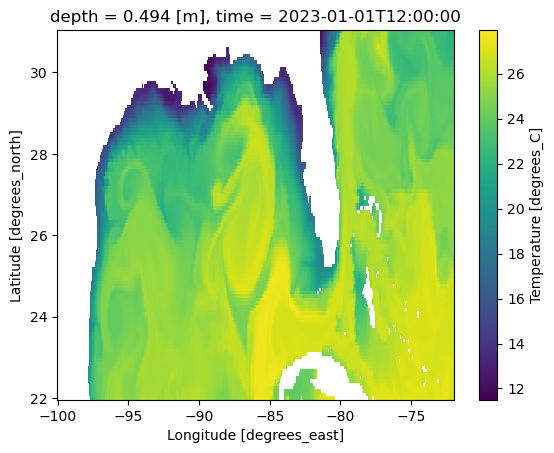

In [35]:
jan.thetao[0,0].plot()

In [22]:
ds.chunk({'depth':-1, 'latitude':-1, 'time':1, 'longitude':-1})

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, time: 304, longitude: 337)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 109, 337), meta=np.ndarray>
Attributes: (12/13)
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    title:             daily mean fields from Global Ocean Physics Analysis a...
    area:              Global
    Conventions:       CF-1.8
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    ...                ...
    source:            MOI GLO12
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    institution:       Mercator Ocean International
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    comment:           
    history:           Data extracted from dataset http://localhost:8080/thre...

In [20]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [21]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.dc164bb3dbd542fea0f8ee560d2f7fe0/status,


In [25]:
#uploading 3D temp
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOPAF/datasets/3D-pottemp.zarr')
ds.chunk({'depth':-1, 'latitude':-1, 'time':1, 'longitude':-1}).to_zarr(gcsmap_ds, mode='w')

In [28]:
check = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOPAF/datasets/3D-pottemp.zarr'))

In [29]:
check

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, longitude: 337, time: 304)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
Data variables:
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 109, 337), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.8
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    area:              Global
    comment:           
    contact:           https://marine.copernicus.eu/contact
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    ...                ...
    institution:       Mercator Ocean International
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    references:        http://marine.copernicus.eu
    source:            MOI GLO12
    title:             daily mean fields from Global Ocean Physics Analysis a...

In [15]:
! python -m pip install xgcm < 0.7.0

/bin/bash: line 1: 0.7.0: No such file or directory


In [13]:
! python -m pip install copernicus-marine-client

  Obtaining dependency information for copernicus-marine-client from https://files.pythonhosted.org/packages/3e/0f/17a0ab2148af4aa466c958fbc56e52406187bf1208fb4eab05bddc2087c6/copernicus_marine_client-0.10.4-py3-none-any.whl.metadata
  Using cached copernicus_marine_client-0.10.4-py3-none-any.whl.metadata (17 kB)
  Obtaining dependency information for cachier<3.0.0,>=2.2.1 from https://files.pythonhosted.org/packages/8f/69/8caf07371931b663a0eb722d618fee5a369811693fa6ec6b03fd53299986/cachier-2.2.2-py2.py3-none-any.whl.metadata
  Using cached cachier-2.2.2-py2.py3-none-any.whl.metadata (19 kB)
  Using cached motuclient-1.8.8-py3-none-any.whl
  Obtaining dependency information for nest-asyncio<2.0.0,>=1.5.8 from https://files.pythonhosted.org/packages/0d/d0/ffa604feb4992d5ecb3a0581df1afa6f5a05027c29c49db867acd7e4e10e/nest_asyncio-1.5.9-py3-none-any.whl.metadata
  Using cached nest_asyncio-1.5.9-py3-none-any.whl.metadata (2.8 kB)
  Obtaining dependency information for semver<4.0.0,>=3.0.2 

In [16]:
import copernicus_marine_client as copernicusmarine

copernicusmarine.subset(
  dataset_id="cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m",
  variables=["thetao"],
  minimum_longitude=-100,
  maximum_longitude=-72,
  minimum_latitude=22,
  maximum_latitude=31,
  start_datetime="2023-01-01T00:00:00",
  end_datetime="2023-11-30T23:59:59",
  minimum_depth=0.49402499198913574,
  maximum_depth=0.49402499198913574,
)

username:

  sbailey2


password:

  ········


ValueError: _Service(service_name=<_ServiceName.FILES: 'original-files'>, short_name=<_ServiceShortName.FILES: 'files'>) is not a valid CopernicusMarineDatasetServiceType

In [2]:
gopaf_ds = xr.merge([xr.open_dataset(f) for f in glob.glob('/home/jovyan/MHW-WMT/GOPAF-data/*.nc')])

OSError: [Errno -101] NetCDF: HDF error: '/home/jovyan/MHW-WMT/GOPAF-data/glo12_rg_1d-m_20230125-20230125_3D-thetao_hcst_R20230208.nc'

In [1]:
pwd

'/home/jovyan/MHW-WMT'

In [12]:
! pip install xgcm<0.7.0

/bin/bash: line 1: 0.7.0: No such file or directory


In [13]:
!pip install copernicus_marine_client

In [14]:
# Import modules
import copernicus_marine_client as copernicusmarine
from pprint import pprint

In [ ]:
copernicusmarine.get()

In [15]:
catalogue = copernicusmarine.describe(contains=["001_024"], include_datasets=True)
pprint(catalogue)

ValueError: _Service(service_name=<_ServiceName.FILES: 'original-files'>, short_name=<_ServiceShortName.FILES: 'files'>) is not a valid CopernicusMarineDatasetServiceType

In [6]:
# Call the get function to save data
get_result_dailymean_2023 = copernicusmarine.get(
    dataset_id = 'cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m',
    filter = "*2023*.nc",
    no_directories = True,
    output_directory = "/home/jovyan/MHW-WMT/GOPAF-data" 
)

pprint(f"List of saved files: {get_result_dailymean_2023}")

username:

  sbailey2


password:

  ········


ValueError: _Service(service_name=<_ServiceName.FILES: 'original-files'>, short_name=<_ServiceShortName.FILES: 'files'>) is not a valid CopernicusMarineDatasetServiceType

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_mfdataset('*.nc', chunks={})

In [3]:
ds

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, longitude: 336, time: 305)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01
Data variables:
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(90, 50, 109, 336), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(90, 50, 109, 336), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.11
    title:             daily mean fields from Global Ocean Physics Analysis a...
    institution:       Mercator Ocean International
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MOI GLO12
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_ANALYSISFORECAST_PHY_001_024
    subset:datasetId:  cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_202211
    subset:date:       2024-02-12T18:38:44.384Z

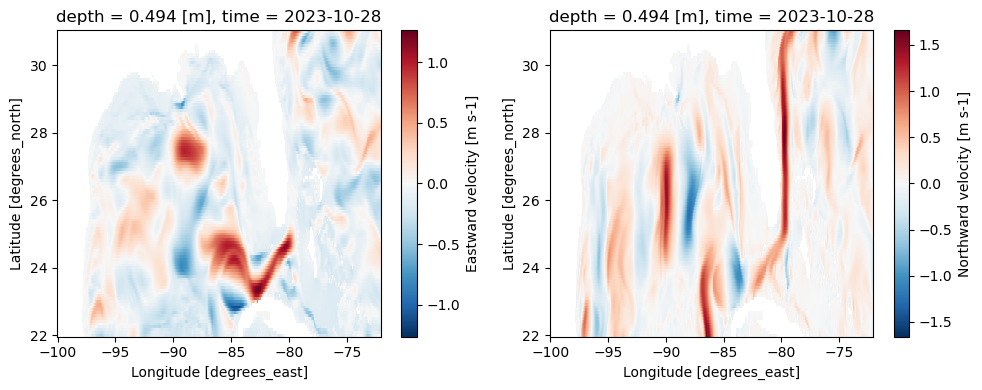

In [5]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
ds.uo[300,0].plot(ax=ax0)
ds.vo[300,0].plot(ax=ax1)
plt.tight_layout()

In [15]:
ds.uo.chunk({'time':10, 'depth':-1, 'longitude':-1, 'latitude':-1})

<xarray.DataArray 'uo' (time: 305, depth: 50, latitude: 109, longitude: 336)>
dask.array<rechunk-merge, shape=(305, 50, 109, 336), dtype=float32, chunksize=(10, 50, 109, 336), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01
Attributes:
    units:          m s-1
    standard_name:  eastward_sea_water_velocity
    long_name:      Eastward velocity

In [16]:
#uploading u,v velocities
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOPAF/datasets/vels.zarr')
ds.chunk({'time':10, 'depth':-1, 'longitude':-1, 'latitude':-1}).to_zarr(gcsmap_ds, mode='w')